In [1]:
dsfolder = "G:\\My Drive\\PalankerLab\\retinal modeling\\datasets\\"

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import random
from itertools import groupby, product
from scipy import optimize, stats
import shapely
from shapely.geometry import Polygon, Point
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda
import torch.nn.functional as F
import torch.nn.init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable

%matplotlib inline

In [14]:
# convert times among three systems: real, mea, wn

def timeConversion(t, source = "mea", target = "wn", WNType = "N"):
  
  meaRepRate = 20000
  if WNType == "N":
    stimRepRate = 1 / (33.27082098251457/1000)
  else:
    stimRepRate = 1 / (49.90624667553192/1000)
  
  if source == "mea":
    t = np.divide(t, meaRepRate)
  elif source == "wn":
    t = np.divide(t, stimRepRate)
  elif source == "ms":
    t = np.divide(t, 1000)
  
  if target == "mea":
    t = np.multiply(t, meaRepRate)
  elif target == "wn":
    t = np.multiply(t, stimRepRate)
  elif target == "ms":
    t = np.multiply(t, 1000)
  
  return t


# =====================
# compute STA

def getSTA(experiment,  whiteNoise, staLength = 25, verbose = "on", normalize = False):

  startTime = experiment['info']['startTime']
  skipped = 0
  STA = np.zeros((staLength * 2, experiment['info']['WNShape'][0], experiment['info']['WNShape'][1]))

  st_wn = timeConversion(np.array(experiment["spikeTimes"]) - startTime, source = "mea", target = "wn", WNType = experiment['info']['WNType'])
  st_frame = np.ceil(st_wn).astype(int)
  st_frame = st_frame[st_frame >= (staLength * 2 - 1)]

  #for i, st in enumerate(experiment["spikeTimes"]):
  for i, st in enumerate(st_frame):
    # if st < timeConversion(staLength * 2 - 1, source = "wn", target = "mea", WNType = experiment['info']['WNType']) + startTime:
    #   skipped += 1
    #   continue
    if i % 2000 == 0 and verbose == "on":
      print(f"Computing spike {i} out of {len(experiment['spikeTimes'])}; using frame {st_frame}")

    # st_wn = timeConversion(st - startTime, source = "mea", target = "wn")
    # st_frame = int(np.ceil(st_wn))
    shift = 0
    try:
      STA += whiteNoise[st-staLength * 2 + 1 + shift:st + 1 + shift, :, :]
    except:
      print(f"Terminated on spike #{i}")
      print(f"Spike time at {st}. White noise length: {whiteNoise.shape[0]}")
      break

  STA /= (i - 1 - skipped)
  if normalize == True: STA = (STA - np.mean(STA)) / (STA.max(axis = 0) - STA.min(axis = 0))
  
  return STA


# =====================
# Bin generator signals

def getGenerator(experiment, whiteNoise, STA):
  print(f"STA dimensions: {STA.shape}")
  print(f"WN dimensions: {whiteNoise.shape}")
  MAX = STA.max(axis = None)
  MIN = STA.min(axis = None)
  MEAN = np.mean(STA, axis = None)
  
  stimulus = np.zeros(STA.shape)
  numStim = whiteNoise.shape[0] - STA.shape[0] + 1
  generator = np.zeros((numStim,))
  #kernel = np.flip(STA, axis = 0)
  #kernel = (STA[:,:,::-1] - MEAN) / (MAX - MIN)
  kernel = (STA - MEAN) / (MAX - MIN)
  
  for i in range(numStim):
    generator[i] = np.sum(np.multiply(whiteNoise[i:i + STA.shape[0],:,:], kernel), axis = None)
  
  return np.array(generator)


# =====================
# Get responses

def getResponse(experiment):
  refreshPeriod = timeConversion(experiment['info']['refreshPeriod'], source = "ms", target = "mea", WNType = experiment['info']['WNType'])
  spikeTimes = np.array(experiment['spikeTimes']) - experiment['info']['startTime'] - (STA.shape[0]) * refreshPeriod
#   spikeTimes = np.floor(spikeTimes)
  spikeTimes = np.floor(spikeTimes[spikeTimes > 0] / refreshPeriod)
  response = [len(list(group)) for key, group in groupby(spikeTimes)]
  
#   respLen = int(experiment['info']['wn']['duration'])
#   response = np.zeros((respLen,))
  
#   for i in range(respLen):
#     for j in range(len(spikeTimes)):
#       if np.floor(spikeTimes[j] / refreshPeriod) == i:
#         response[i] += 1
#       else:
#         if j == 0: break
#         spikeTimes = np.delete(spikeTimes, np.arange(j))
#         break

  return np.array(response)


# =====================
# Compute nonlinear function

def getNL(generator, response, shift, nbins = 800):
  MAX = np.max(generator)
  MIN = np.min(generator)
  INT = (MAX - MIN) / nbins
  
  counts = np.zeros((nbins, 2))
  length = np.min([generator.shape[0] , response.shape[0]])
  
  for i in range(length):
    if i+shift > len(response)-1: break
    binNum = int(np.ceil((generator[i] - MIN) / INT) + 1)
    counts[binNum, 0] += response[i+shift]
    counts[binNum, 1] += 1
  
  return np.divide(counts[:,0], counts[:,1])


# =====================
# Get average stimulus given a generator

def stimulationFromGenerator(whiteNoise, STA, generator, signal, width, shift, plot = "on"):
  idx = np.where(((np.absolute(generator - signal) < width / 2)) == 1)[0]
  idx = np.array(idx).astype(dtype = int)
  avgStim = np.zeros(STA.shape)
  for _,i in enumerate(idx):
    avgStim += whiteNoise[i + shift:i + shift + STA.shape[0], :, :]
  
  avgStim /= len(idx)
  
  if plot == "on":
    plt.figure(num = None, figsize = (np.ceil(avgStim.shape[0]/2),2))
    for i in range(avgStim.shape[0]):
      plt.subplot(2, np.ceil(avgStim.shape[0]/2), i+1)
      plt.imshow(avgStim[i,:,:])
      plt.clim(avgStim.min(axis = None), avgStim.max(axis = None))
      plt.axis('off')
    
  return avgStim, idx


# =====================
# Get raster data with a given generator range

def rasterFromGenerator(experiment, generator, genRange, t):
  
  refreshPeriod = timeConversion(experiment['info']['refreshPeriod'], source = 'ms', target = 'mea', WNType = experiment['info']['WNType'])
  #print(refreshPeriod)
  generator = np.array(generator)
  staLength = experiment['info']['STALength']
  idx = np.where(((np.absolute(generator - genRange[0]) < genRange[1] / 2)) == 1)[0]
  trialTimes = timeConversion(idx, 
                              source = "wn", 
                              target = "mea", 
                              WNType = experiment['info']['WNType'])
  trialTimes += experiment['info']['startTime'] + (staLength-4) * refreshPeriod
  spikeTimes = np.array(experiment['spikeTimes'])
  
  raster = dict()
  for i in range(len(trialTimes)):
    spikes = np.where(np.logical_and(spikeTimes > trialTimes[i], spikeTimes < trialTimes[i] + t))[0]
    #if spikes.shape[0] == 0: continue
    trial = np.array([spikeTimes[j] for j in spikes]) - trialTimes[i] #- (staLength-1) * refreshPeriod
    #spikeTimes.remove(spikeTimes[(trialTimes[i] - spikeTimes).any()])
#     mask = np.ones_like(spikeTimes)
#     mask[:spikes[0]] = False
#     spikeTimes = spikeTimes[mask]
    raster[i] = trial
    
  return raster, idx


# =====================
# Plot raster

def plotRaster(raster, WNType):
  for i, trial in raster.items():
    if len(trial) == 0: continue
    trial = timeConversion(trial, source = "mea", target = "real", WNType = WNType)
    plt.scatter(trial, i * np.ones(len(trial)), c = 'tab:blue', s = 1)
  return None


# =====================
# Lists in dictionary to Numpy arrays

def dictLists2npArray(d):
  for k, v in d.items():
    if isinstance(v, dict):
      dictLists2npArray(v)
    elif isinstance(v, list):
      d[k] = np.array(v)


# =====================
# Make geometries

def makeHexagon(l, s = 1):
  a1 = [s * np.cos(np.pi/6), s * np.sin(np.pi/6)]
  corners = [np.array(l)]
  corners.append(l + np.array([a1[0], -a1[1]]))
  corners.append(l + np.array([2 * a1[0], 0]))
  corners.append(l + np.array([2 * a1[0], s]))
  corners.append(l + np.array([a1[0], s + a1[1]]))
  corners.append(l + np.array([0, s]))
  return corners

def makeRectangle(l = (0,0), dim = (1,1)):
  corners = [np.array(l)]
  corners.append(l + np.array([dim[0], 0]))
  corners.append(l + np.array([dim[0], dim[1]]))
  corners.append(l + np.array([0, dim[1]]))
  return corners

def makeBar(center, width, angle):
  R = np.array([[np.cos(angle), -np.sin(angle)], 
                [np.sin(angle), np.cos(angle)]])
  center = np.array(center)
  corners = np.array([[-40, -width/2],
             [-40, width/2],
             [40, width/2],
             [40, -width/2]])
  newCorners = np.matmul(R,corners.T)
  newCorners = newCorners.T + center
  return newCorners

def makeLandoltC(center, diameter, angle):
  R = np.array([[np.cos(angle), -np.sin(angle)], 
                [np.sin(angle), np.cos(angle)]])
  center = np.array(center)
  outer = Polygon(Point(*center).buffer(diameter/2))
  inner = Polygon(Point(*center).buffer (diameter/2 - diameter/5))
  ring = outer.difference(inner)
  opening = np.array([[0, -diameter/10],
                     [diameter/2, -diameter/10],
                     [diameter/2, diameter/10],
                     [0, diameter/10]])
  opening = Polygon(np.matmul(R,opening.T).T + center)
  landoltC = ring.difference(ring.intersection(opening))
  return landoltC
  

# =====================
# Make bar for hexgonal lattice

def buildBarStimulus(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]
  hexCoord = makeHexagon(origin, 1)
  hx = Polygon(hexCoord)

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  hx_dict = dict()
  hx_coord = []

  bar = Polygon(makeBar(center, width, angle))
  inter = dict()

  for x, y in xylist:
    xx = np.cos(np.pi/6) * (2*x+y-2*np.floor(y/2))
    yy = 1.5 * y
    hx_coord.append([xx, yy])
    hx_dict[(x,y)] = Polygon(makeHexagon([xx,yy], 1))
    inter[(x,y)] = hx_dict[(x,y)].intersection(bar).area / hx_dict[(x,y)].area #/ 2 + 0.5

  outStim = np.zeros((dims[0],dims[1],dims[2])) #* 0.5
  for x in range(dims[1]):
    for y in range(dims[2]):
      outStim[startFrame:, x, y] = inter[(x,y)]

  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), hx in hx_dict.items():
      xl, yl = hx.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*hx.centroid.xy, alpha = inter[(x,y)])

    bx, by = bar.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,35)
    plt.ylim(-1,31)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim

# =====================
# Make bar for square lattice

def buildBarStimulus2(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]
  sqCoord = makeRectangle()
  sq = Polygon(sqCoord)

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  sq_dict = dict()
  sq_coord = []

  bar = Polygon(makeBar(center, width, angle))
  inter = dict()

  for x, y in xylist:
    sq_coord.append([x, y])
    sq_dict[(x,y)] = Polygon(makeRectangle([x,y]))
    inter[(x,y)] = sq_dict[(x,y)].intersection(bar).area / sq_dict[(x,y)].area #/ 2 + 0.5

  outStim = np.ones((dims[0],dims[1],dims[2])) #* 0.5
  for x in range(dims[1]):
    for y in range(dims[2]):
      outStim[startFrame:, x, y] = inter[(x,y)]

  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), sq in sq_dict.items():
      xl, yl = sq.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*sq.centroid.xy, alpha = inter[(x,y)])

    bx, by = bar.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,65)
    plt.ylim(-1,33)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim


# =====================
# Make Landolt C on hexgonal lattice

def buildLandoltCStimulus(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]
  #hexCoord = makeHexagon(origin, 1)
  #hx = Polygon(hexCoord)

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  c_dict = dict()
  c_coord = []

  print(f"{center} {width} {angle}")
  C = makeLandoltC(center, width, angle)
  inter = dict()

  for x, y in xylist:
    xx = np.cos(np.pi/6) * (2*x+y-2*np.floor(y/2))
    yy = 1.5 * y
    c_coord.append([xx, yy])
    c_dict[(x,y)] = Polygon(makeHexagon([xx,yy], 1))
    inter[(x,y)] = c_dict[(x,y)].intersection(C).area / c_dict[(x,y)].area #/ 2 + 0.5

  outStim = np.zeros((dims[0],dims[1],dims[2])) #* 0.5
  for x in range(dims[1]):
    for y in range(dims[2]):
      outStim[startFrame:, x, y] = inter[(x,y)]

  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), c in c_dict.items():
      xl, yl = c.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*c.centroid.xy, alpha = inter[(x,y)])

    bx, by = C.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,35)
    plt.ylim(-1,31)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim

def buildLandoltCStimulus_natural(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  c_dict = dict()
  c_coord = []

  print(f"{center} {width} {angle}")
  C = makeLandoltC(center, width, angle)
  
  outStim = np.zeros((dims[0],dims[1],dims[2])) #* 0.5

  for x, y in xylist:
    c_dict[(x,y)] = Polygon(makeRectangle([x,y], (1, 1)))
    outStim[startFrame:, x, y] = c_dict[(x,y)].intersection(C).area / c_dict[(x,y)].area #/ 2 + 0.5

  
#   for x in range(dims[1]):
#     for y in range(dims[2]):
#       outStim[startFrame:, x, y] = inter[(x,y)]

  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), c in c_dict.items():
      xl, yl = c.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*c.centroid.xy, alpha = outStim[-1,x,y])

    bx, by = C.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,35)
    plt.ylim(-1,31)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim

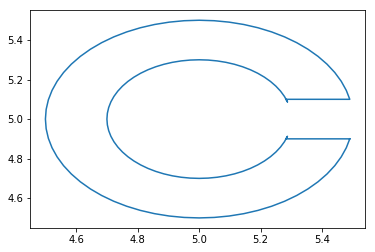

In [42]:
landoltC =  makeLandoltC((5, 5), 1, 0)
xl, yl = landoltC.exterior.xy
plt.plot(xl, yl)

In [9]:
cellfile = 'retina_LE_V.json'
#cellfile = 'retina_LE_E.json'
#cellfile = 'retina_RCS_E.json'
#filename = 'RCS_spikeTimes_cell391.json'
#filename = 'LE_E_spikeTimes_cell301.json'
with open(dsfolder + cellfile,"r") as datafile:
  cell = json.load(datafile)

# counter = 0
# cell = dict()
# for key, val in cell1.items():
#     counter += 1
#     if key == '5311' or key == '5566': cell[key] = val

#print(cell)
dictLists2npArray(cell)

In [30]:
#  === EDIT THIS BLOCK ===
n_output = 2
lum = (0.5, 1)
tol = 0.1
horizBar = (7, 2) #(start, width)
vertBar = (7, 2)
startFrame = 13
# === ===

# 2. 
plotDuration = timeConversion(2, source = 'real', target = 'mea', WNType = 'N')
binWidth = timeConversion(0.01, source = 'real', target = 'mea', WNType = 'N')
nbins = int(plotDuration / binWidth)

popRaster = dict()
spikingPattern = dict()
spikingPattern['info'] = dict()
spikingPattern['info']['stimulusType'] = 'crossbar'


# 3.
stims = dict()

WNType = cell[random.choice(list(cell.keys()))]['experiment']['info']['WNType']

if WNType == 'N': dims = (24,64,32)
else: dims = (24,20,20)

start_time = time.time()
params = dict()
outStim = dict()
for i in range(4):
  params[i] = dict()
  params[i]['center'] = (30,12)#(32, 12) #(17,15)
  params[i]['width'] = 16
  params[i]['angle'] = np.pi/2 * i
  params[i]['startFrame'] = 21
  params[i]['dims'] = dims
  if WNType == 'N':
    #outStim[i] = buildBarStimulus2(params[i], visualize = True)
    outStim[i] = buildLandoltCStimulus_natural(params[i], visualize = False)
  else:
    #outStim[i] = buildBarStimulus(params[i], visualize = True)
    outStim[i] = buildLandoltCStimulus(params[i], visualize = True)

end_time = time.time()
print(f"Elapsed time: {end_time - start_time} secs")
    
for j in ('dims','lum','plotDuration','binWidth','nbins', 'tol'):
  spikingPattern['info'][j] = locals()[j]


(30, 12) 16 0.0
(30, 12) 16 1.5707963267948966
(30, 12) 16 3.141592653589793
(30, 12) 16 4.71238898038469
Elapsed time: 1.1917555332183838 secs


In [6]:
lC_stimulus_file = "G:\My Drive\PalankerLab\\retinal modeling\datasets\landoltc\landoltC_stimulus_dict.json"
with open(lC_stimulus_file, 'r') as f_in:
    landoltC_stimulus_dict = json.load(f_in)

In [32]:
#  === EDIT THIS BLOCK ===
center = (14,14)
width = 16

# === ===

# 2. 
plotDuration = timeConversion(2, source = 'real', target = 'mea', WNType = 'N')
binWidth = timeConversion(0.01, source = 'real', target = 'mea', WNType = 'N')
nbins = int(plotDuration / binWidth)

popRaster = dict()
spikingPattern = dict()
spikingPattern['info'] = dict()
spikingPattern['info']['stimulusType'] = 'crossbar'


# 3.
stims = dict()

WNType = cell[random.choice(list(cell.keys()))]['experiment']['info']['WNType']

if WNType == 'N': dims = (24,64,32)
else: dims = (24,20,20)

params = dict()
outStim = dict()
for i in range(4):
    keystring = '(('+ str(center[0]) + ', ' + str(center[1]) + '), ' + str(width) + ', ' + str(i)+ ')'
    outStim[i] = np.array(landoltC_stimulus_dict[keystring]['stimulus'])
    params[i] = np.array(landoltC_stimulus_dict[keystring]['params'])

In [106]:
rast, idx_h = rasterFromGenerator(experiment, generator, (-3, tol), plotDuration)
rast = np.array([k for i,k in rast.items()])
counts = np.zeros((len(rast), ))
for i, r in enumerate(rast):
    #plt.scatter(r, np.ones_like(r) * i, s=0.5)
    counts[i] = len(r)
    #if i == 50: break
print(np.average(counts)/nbins)
print(np.average([len(aa) for aa in rast])/nbins/len(rast))
print(np.concatenate(rast).ravel())

0.07595978062157221
0.00013886614373230752
[ 1710.50664894  3834.50664894  5753.50664894 ... 34044.93111701
 36005.93111701 38360.93111701]


301
Generator 0: 1.7934266308725282
Generator 1: 2.183995372370781
Generator 2: 1.932425487083772
Generator 3: 1.4585901861781525
200 9689
200 9231
200 9547
200 9501


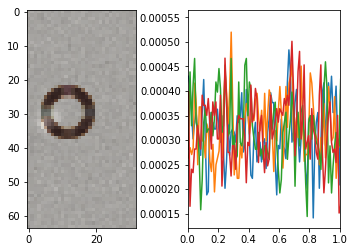

5328
Generator 0: 4.163098850666348
Generator 1: 4.350784783060426
Generator 2: 4.320426499955374
Generator 3: 2.822685442680169
200 6105
200 6098
200 6227
200 6308


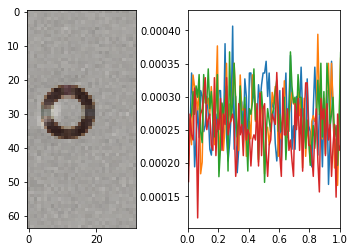

5447
Generator 0: 3.9240625368926247
Generator 1: 4.274078218794607
Generator 2: 4.002131133158144
Generator 3: 2.8272319147027187
200 4530
200 4527
200 4310
200 4886


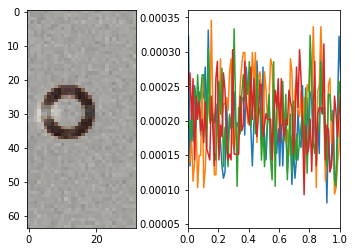

4276
Generator 0: -5.376722421183043
Generator 1: -4.112952506787049
Generator 2: -4.35801496344629
Generator 3: -5.29332532593927
200 7390
200 10271
200 10280
200 7777


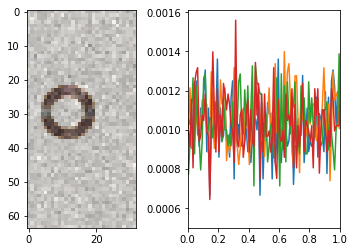

5147
Generator 0: -2.0693008552065244
Generator 1: -1.3218704363405003
Generator 2: -1.7118571172033312
Generator 3: -1.8686317622586543
200 18220
200 23186
200 21122
200 20657


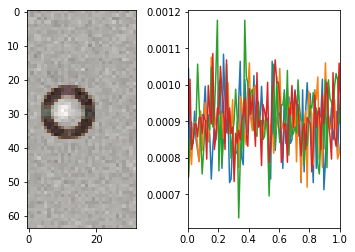

5192
Generator 0: -4.7376072638472895
Generator 1: -3.4591856023216696
Generator 2: -4.213298846632092
Generator 3: -4.037540855637394
200 6078
200 8045
200 6667
200 7330


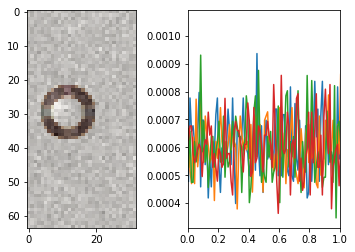

5206
Generator 0: 0.7727181782946811
Generator 1: 1.08340684897826
Generator 2: 0.8258239418793051
Generator 3: 0.10743975011448204
200 6103
200 5598
200 6282
200 5802


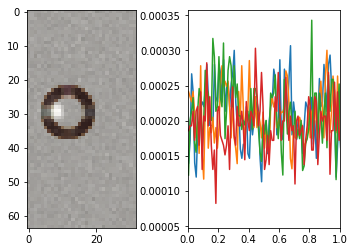

4771
Generator 0: 0.432748613338657
Generator 1: 0.628492430078333
Generator 2: -0.24313107382058147
Generator 3: -0.08594673813477577
200 2823
200 2771
200 2597
200 2752


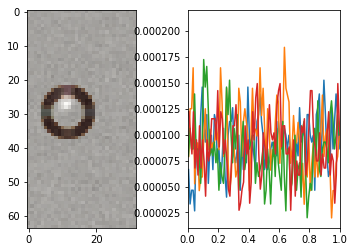

4051
Generator 0: 2.8194712594834304
Generator 1: 2.6789948428047956
Generator 2: 3.084014262189068
Generator 3: 2.6493281785744043
200 9853
200 10084
200 10189
200 9842


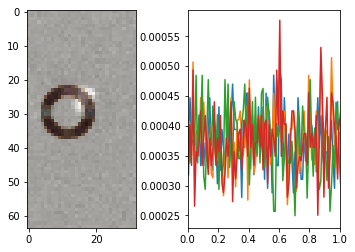

5117
Generator 0: -5.883810147028601
Generator 1: -5.023094341381333
Generator 2: -4.830723799262352
Generator 3: -5.9045282494889495
200 5786
200 7616
200 7287
200 5401


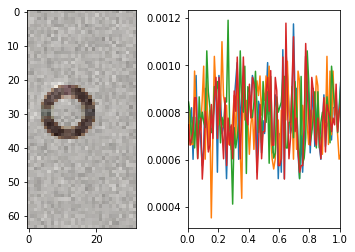

4861
Generator 0: -6.024177407134607
Generator 1: -5.126986912555829
Generator 2: -3.8413182146050913
Generator 3: -6.480339871593118
200 4963
200 7035
200 8755
200 4990


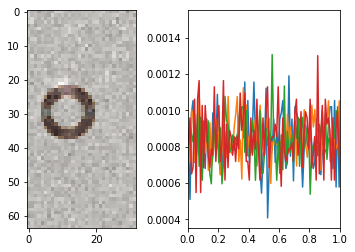

5193
Generator 0: -1.9930279249713398
Generator 1: -1.3141494670808913
Generator 2: -1.6648235963343736
Generator 3: -1.8696577135595638
200 19395
200 23035
200 21273
200 19742


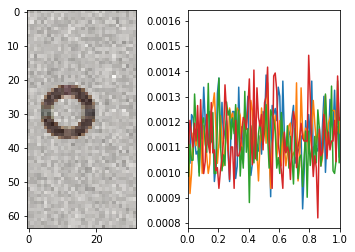

4531
Generator 0: -3.8095393113011315
Generator 1: -2.747839518351025
Generator 2: -2.8027049256738197
Generator 3: -3.8214231905810294
200 8156
200 11596
200 10723
200 7994


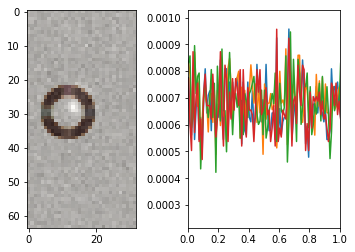

4039
Generator 0: -4.920678127601374
Generator 1: -3.445489046034048
Generator 2: -4.329026542513484
Generator 3: -4.64826487810202
200 3986
200 5586
200 4456
200 4119


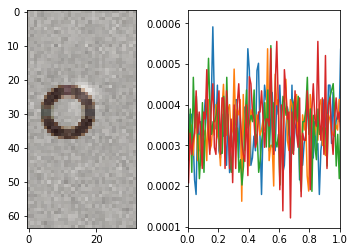

4096
Generator 0: -6.277679762155984
Generator 1: -3.858493282022339
Generator 2: -6.340541768103817
Generator 3: -6.531879231123377
200 4253
200 10480
200 4176
200 4277


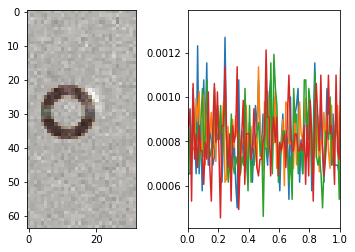

4516
Generator 0: -5.5971335357909595
Generator 1: -4.3704802803699065
Generator 2: -3.308630555574477
Generator 3: -5.915592226740504
200 9036
200 14713
200 16419
200 9755


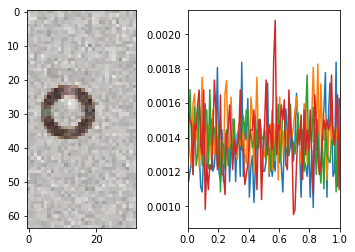

4726
Generator 0: -1.1827355758082332
Generator 1: -0.48700063386639203
Generator 2: -0.8598381710231104
Generator 3: -1.2624728808798247
200 28834
200 33693
200 30322
200 26748


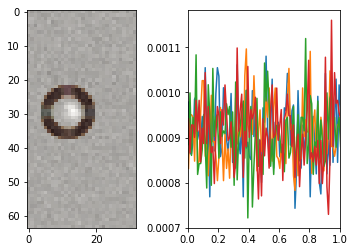

4636
Generator 0: 1.7051302315714545
Generator 1: 2.5862515671635
Generator 2: 0.9558816355503577
Generator 3: 2.2836092949255598
200 8152
200 7749
200 7878
200 8401


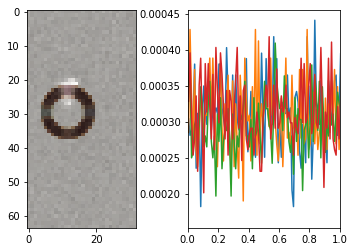

4981
Generator 0: -0.42768085318953786
Generator 1: 0.39901872176925746
Generator 2: -0.4745296479642863
Generator 3: -0.39438927038053584
200 12792
200 13253
200 12625
200 13231


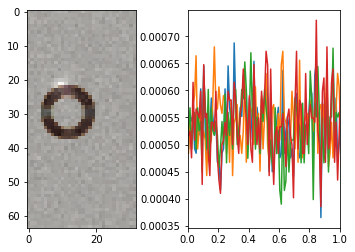

5148
Generator 0: 2.0634469866727443
Generator 1: 1.8452933023073863
Generator 2: 1.8015929851308843
Generator 3: 1.0526344014194042
200 6150
200 6661
200 6378
200 6282


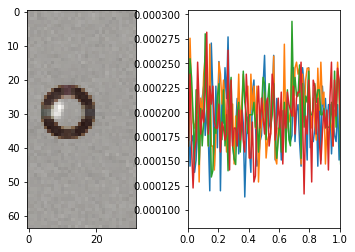

5296
Generator 0: -5.764628458099292
Generator 1: -4.022530201215667
Generator 2: -5.046330462213555
Generator 3: -5.394609043802408
200 10894
200 12310
200 11948
200 11669


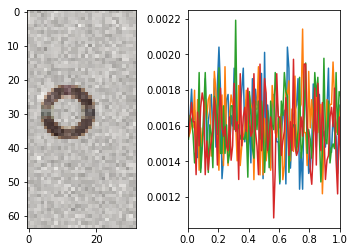

5297
Generator 0: 3.7619807915346057
Generator 1: 3.9006669759540866
Generator 2: 3.79884182583929
Generator 3: 2.6701897028762103
200 8846
200 8957
200 9373
200 9708


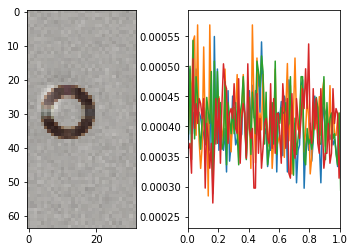

4066
Generator 0: 0.6828956618630619
Generator 1: 0.5441523927748948
Generator 2: 1.0414748855868687
Generator 3: 0.6150609232773778
200 14926
200 14627
200 15596
200 15341


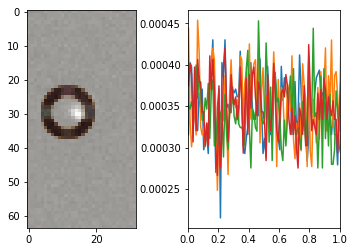

4307
Generator 0: -5.1723607566979695
Generator 1: -2.8632269430396615
Generator 2: -5.057199885289172
Generator 3: -5.22174063630838
200 5004
200 11620
200 5567
200 5064


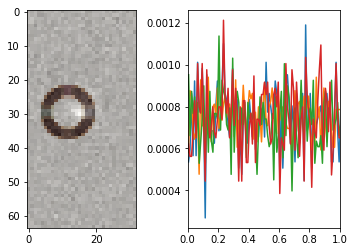

692
Generator 0: 1.4453664140237636
Generator 1: 2.47468194741558
Generator 2: 2.5436938302863874
Generator 3: 2.1441814476028913
200 16223
200 15733
200 15446
200 15085


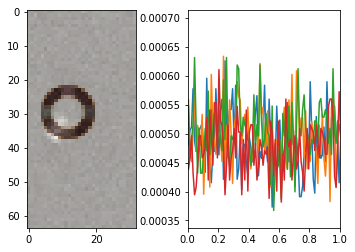

632
Generator 0: -2.4269417012664385
Generator 1: -1.9532850122749152
Generator 2: -2.2616675940489492
Generator 3: -2.8489046350253444
200 12040
200 14360
200 15093
200 12673


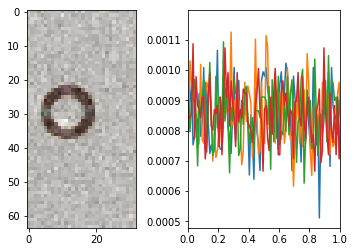

992
Generator 0: -2.590055797739126
Generator 1: -3.2725188543576396
Generator 2: -3.3106662922805787
Generator 3: -3.91869680445674
200 11066
200 9573
200 9270
200 7108


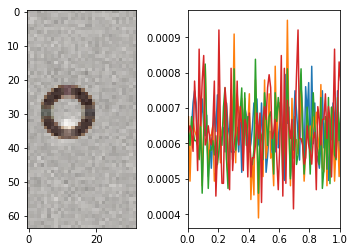

559
Generator 0: -1.1615581610885324
Generator 1: -0.6648663367200432
Generator 2: -1.3771891851140547
Generator 3: -0.871510344546039
200 4732
200 4615
200 4424
200 4897


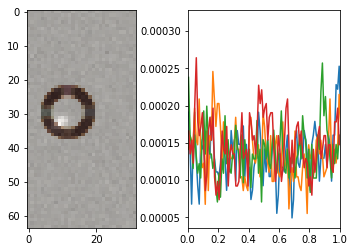

378
Generator 0: 1.1553288789367349
Generator 1: 1.789224626096264
Generator 2: 1.126790695140655
Generator 3: 0.9081307374648615
200 2068
200 2251
200 2050
200 2139


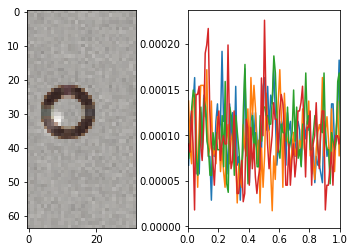

437
Generator 0: -3.737021446201542
Generator 1: -3.590042621441354
Generator 2: -4.256181610021994
Generator 3: -4.665929371232894
200 7403
200 7808
200 6647
200 6337


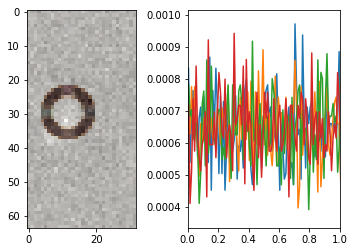

241
Generator 0: -6.536100898896583
Generator 1: -5.1045390624968165
Generator 2: -6.360087813507471
Generator 3: -5.586269133504064
200 4746
200 6239
200 4832
200 5233


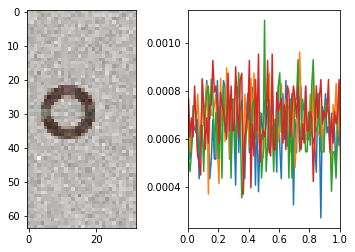

271
Generator 0: -4.496519024635538
Generator 1: -3.6532467768738845
Generator 2: -4.610974844643566
Generator 3: -4.1684161541611395
200 9106
200 12876
200 9057
200 10032


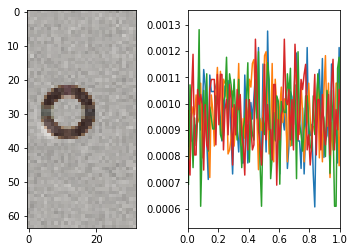

557
Generator 0: 2.670116080961624
Generator 1: 3.148989850859393
Generator 2: 3.4464858284499207
Generator 3: 2.805230036085339
200 10057
200 10045
200 10318
200 9983


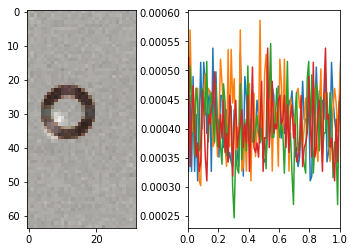

436
Generator 0: -3.0291763477601203
Generator 1: -1.623343603733806
Generator 2: -2.605104509119621
Generator 3: -2.302624662176657
200 15644
200 19848
200 14562
200 18493


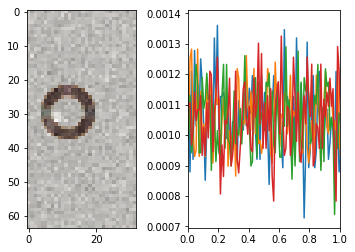

781
Generator 0: -2.377647462350977
Generator 1: -1.2089718529344986
Generator 2: -1.8391949431506114
Generator 3: -2.210175275744009
200 21994
200 23774
200 24164
200 21760


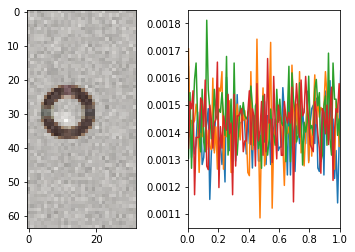

842
Generator 0: -1.766465055915651
Generator 1: -1.2986199485556513
Generator 2: -1.4534235082077145
Generator 3: -1.8681799362240161
200 15805
200 18134
200 17804
200 15144


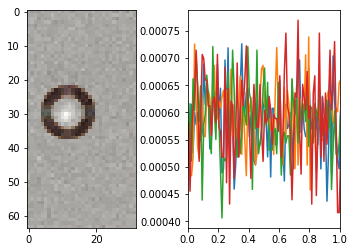

994
Generator 0: -1.2491600142282024
Generator 1: -1.0481520884776399
Generator 2: -0.8671433409757019
Generator 3: -0.9021983998974074
200 5830
200 5440
200 6350
200 6324


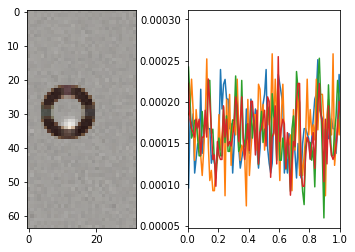

3226
Generator 0: 3.548165556445788
Generator 1: 2.1911477252212546
Generator 2: 4.401588725681144
Generator 3: 3.496211598028567
200 25049
200 24321
200 22911
200 25320


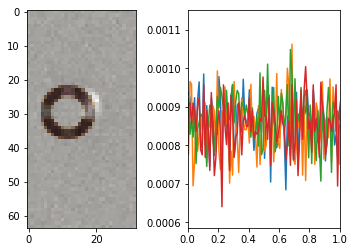

1801
Generator 0: -4.333409519713856
Generator 1: -1.6430820068056704
Generator 2: -4.140518625055872
Generator 3: -4.450678936504878
200 10570
200 25154
200 11554
200 9336


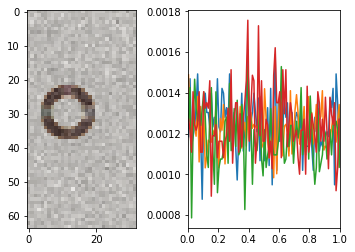

1861
Generator 0: 3.102757463767242
Generator 1: 2.0464695144321574
Generator 2: 3.8500490642588403
Generator 3: 3.2261400544550964
200 21918
200 22282
200 19318
200 20027


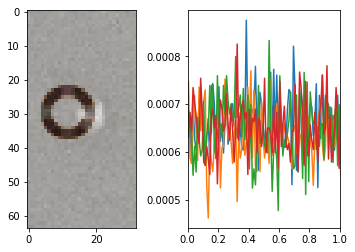

1622
Generator 0: -5.740607649899037
Generator 1: -3.9344157323120394
Generator 2: -5.73245366710764
Generator 3: -5.898846769203379
200 4612
200 9104
200 4582
200 3566


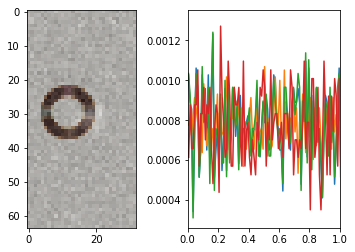

3886
Generator 0: -4.870884361709592
Generator 1: -2.6282709680631884
Generator 2: -4.8951710324847735
Generator 3: -4.9429736486476195
200 4681
200 11521
200 4532
200 4228


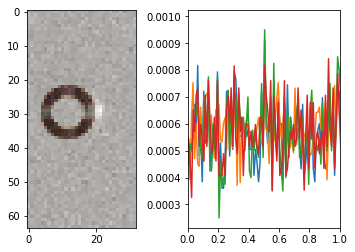

1516
Generator 0: 1.7942473754777921
Generator 1: 1.830468456588201
Generator 2: 2.040981623313313
Generator 3: 1.479335682314325
200 19315
200 19202
200 17890
200 17168


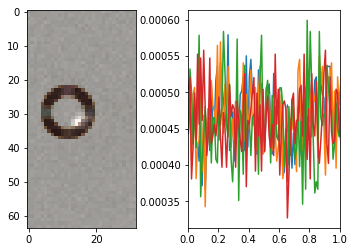

1592
Generator 0: -6.309783618932566
Generator 1: -5.296546252247202
Generator 2: -6.372949709140774
Generator 3: -7.133822106938133
200 4763
200 4834
200 4291
200 3148


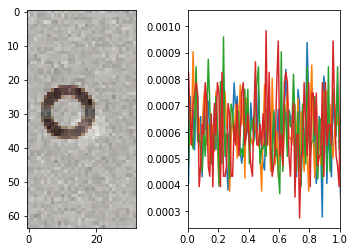

1502
Generator 0: -4.589867856806967
Generator 1: -3.0099749678011474
Generator 2: -4.476954831298834
Generator 3: -4.487538828370688
200 6183
200 13626
200 6375
200 6319


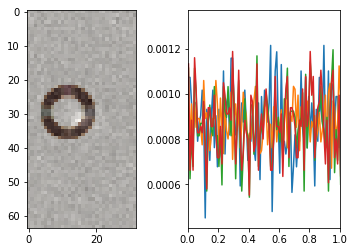

1397
Generator 0: 1.389382061207528
Generator 1: 1.6957991389713796
Generator 2: 1.6314335574173902
Generator 3: 1.5913013650211276
200 4473
200 4616
200 4073
200 4089


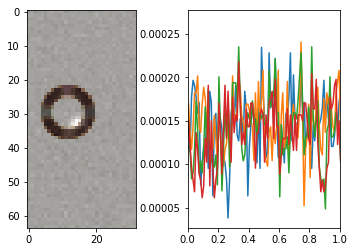

1231
Generator 0: -2.482267041375767
Generator 1: -1.7973518607090693
Generator 2: -2.3500166200892054
Generator 3: -2.649236136339296
200 19177
200 21889
200 19881
200 16771


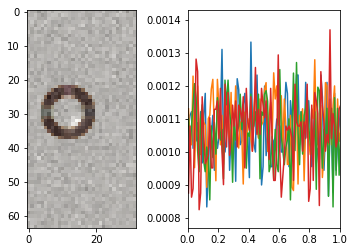

1277
Generator 0: -4.3499985230651035
Generator 1: -4.313898589134122
Generator 2: -4.698786350301974
Generator 3: -5.12938756026455
200 5040
200 5117
200 5351
200 4461


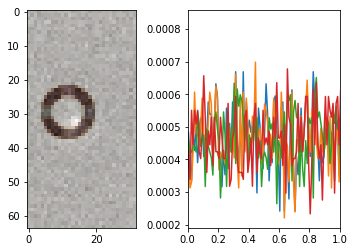

1096
Generator 0: -2.467406793631612
Generator 1: -2.1736942127908145
Generator 2: -2.484085053027164
Generator 3: -2.910404440463471
200 12666
200 14182
200 12716
200 10914


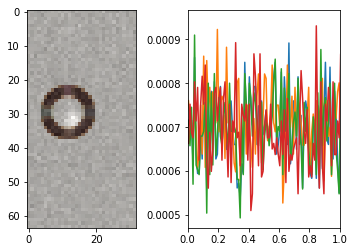

Time elapsed: 17.137577533721924 secs


In [31]:
tol = 0.15
# popRaster = dict()
# spikingPattern = dict()
# spikingPattern['info'] = dict()
# spikingPattern['info']['stimulusType'] = 'crossbar'
# for i in ('dims','lum','horizBar','vertBar','plotDuration','binWidth','nbins', 'tol'):
#   spikingPattern['info'][i] = locals()[i]

spikingStd = dict()
cmap_list = {0: plt.cm.Blues,
             1: plt.cm.Oranges,
             2: plt.cm.Greens,
             3: plt.cm.Reds}
counter = 0

start_time = time.time()

for key, c in cell.items():

  print(key)
  
  STA = np.array(c['STA'])

  MEAN = np.mean(STA)
  MAX = np.max(STA)
  MIN = np.min(STA)
  kernel = (STA - MEAN) / (MAX - MIN)
  
  gen = dict()
  
  for i in range(len(outStim)):
    gen[i] = np.sum(np.multiply(kernel,outStim[i]), axis = None)
    print(f"Generator {i}: {gen[i]}")
  
  popRaster[key] = dict()
  generator = c['generator']
  experiment = c['experiment']
  rasterFlat = dict()
  x1 = dict()
  spikingPattern[key] = dict()
  spikingStd[key] = dict()

  for i in range(len(outStim)):
    popRaster[key][i], idx_h = rasterFromGenerator(experiment, generator, (gen[i], tol), plotDuration)
    rasterFlat[i] = np.array([k for i,k in popRaster[key][i].items()])
    norm = np.average([len(aa) for aa in rasterFlat[i]])/nbins
    rasterFlat[i] = timeConversion(np.concatenate(rasterFlat[i]).ravel(), 
                                   source = "mea", target = "real", WNType = experiment['info']['WNType'])
    
    spikingPattern[key][i] = dict()
    x1[i] = dict()
    print(f"{nbins} {len(rasterFlat[i])}")
    spikingPattern[key][i], x1[i], _ = stats.binned_statistic(rasterFlat[i],
                                                           np.ones_like(rasterFlat[i]) * norm / len(rasterFlat[i]),
                                                           statistic = 'sum',
                                                           bins = nbins)
    spikingStd[key][i], x1[i], _ = stats.binned_statistic(rasterFlat[i],
                                                           np.ones_like(rasterFlat[i]),
                                                           statistic = 'sum',
                                                           bins = nbins)
                                                              #weights = np.ones_like(rasterFlat[i])/len(rasterFlat[i]))
  
  plt.subplot(1,2,1)
  plt.imshow(STA[np.unravel_index(np.argmax(STA, axis = None), STA.shape)[0],:,:], cmap=plt.cm.gray)
  for i in range(len(outStim)):
    plt.imshow(outStim[i][-1,:,:], alpha = 0.2, cmap = cmap_list[i])

    hist1 = stats.binned_statistic(rasterFlat[i],
                                   np.arange(len(rasterFlat[i])),
                                   statistic = 'mean',
                                   bins = nbins)
#     hist1 = plt.hist(rasterFlat[i],
#             bins = nbins,
#             alpha = 0.8,
#             weights=np.ones_like(rasterFlat[i])/len(rasterFlat[i]),
#             histtype = 'stepfilled')

  plt.subplot(1,2,2)
  for i in range(len(outStim)):
    plt.plot((x1[i][1:] + x1[i][:-1]) / 2, spikingPattern[key][i])
    #plt.plot(spikingPattern[key][i])

  plt.xlim((0, 1))
  plt.show()

end_time = time.time()
print(f"Time elapsed: {end_time - start_time} secs")

In [71]:
num_exp = 30000
num_cells = len(cell)
info = spikingPattern['info']
binWidth = timeConversion(info['binWidth'], source = 'mea', target = 'real')
synthTime = 0.5
lastBinEdge = int(synthTime / binWidth)

synthData = np.zeros((num_exp, num_cells))
synthLabel = np.round(len(outStim) * np.random.random((num_exp,)) - 0.5)
synthDataLong = np.zeros((num_exp, num_cells, lastBinEdge))

spikeRate = np.zeros((len(outStim), num_cells, lastBinEdge))
spikeVar = np.zeros((len(outStim), num_cells, lastBinEdge))
count = 0

print(f"Number of cells: {len(cell.keys())}")
print(f"List of cell IDs: {[k for k in cell.keys()]}")

for key, val in cell.items():
  #orientation = 
  for i in range(len(outStim)):
    spikeRate[i, count, :] = spikingPattern[key][i][:lastBinEdge] / binWidth
    spikeVar[i, count, :] = spikeRate[i, count, :] / np.sqrt(spikingStd[key][i][:lastBinEdge])
  count += 1


for n_e in range(num_exp):
  if n_e % 2500 == 0: print(f"Simulating experiment #{n_e}")
  orientation = int(synthLabel[n_e])
  sigma = spikeVar[orientation,:,:]#np.tile(np.std(spikeRate[orientation, :, :], axis = 1).T, (lastBinEdge,1)).T
  #if n_e % 2500 == 0:print(sigma)
  mu = spikeRate[orientation, :, :] #- np.average(sigma, axis = None)
  #if n_e % 2500 == 0:print(mu)
  rng = np.random.rand(*(spikeRate[orientation, :, :].shape))
  rng = (rng < mu).astype(int)
  #rng = np.round(sigma * np.random.randn(*(spikeRate[orientation, :, :].shape)) + mu)
  synthDataLong[n_e, :, :] = rng
  synthData[n_e, :] = np.sum(rng, axis = 1)

print(f"Synthetic data shape: {synthData.shape}")
#print(synthLabel)
#synthLabel = F.one_hot(torch.from_numpy(synthLabel.astype(int)), 2)
#     plt.figure
#     plt.plot(np.arange(spikeRate.shape[0]) * binWidth, rng)
#     plt.show()
    
    #print(spikeDistrib)

Number of cells: 49
List of cell IDs: ['301', '5328', '5447', '4276', '5147', '5192', '5206', '4771', '4051', '5117', '4861', '5193', '4531', '4039', '4096', '4516', '4726', '4636', '4981', '5148', '5296', '5297', '4066', '4307', '692', '632', '992', '559', '378', '437', '241', '271', '557', '436', '781', '842', '994', '3226', '1801', '1861', '1622', '3886', '1516', '1592', '1502', '1397', '1231', '1277', '1096']
Simulating experiment #0
Simulating experiment #2500
Simulating experiment #5000
Simulating experiment #7500
Simulating experiment #10000
Simulating experiment #12500
Simulating experiment #15000
Simulating experiment #17500
Simulating experiment #20000
Simulating experiment #22500
Simulating experiment #25000
Simulating experiment #27500
Synthetic data shape: (30000, 49)


8.0
50
200


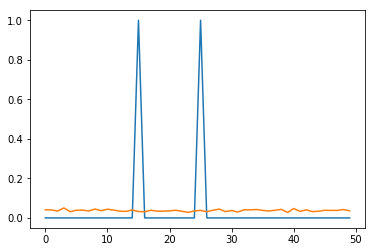

In [44]:
o = 1
ce = 8

plt.plot(synthDataLong[o,ce,:])
print(np.sum(synthDataLong[o,ce,:]) * 4)
plt.plot(spikeRate[o,ce,:])
#idx_h
print(lastBinEdge)
print(nbins)

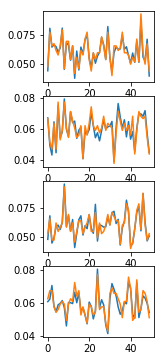

In [65]:
plt.figure
nth_cell = 5

plt.figure(figsize=(2, 6))
idx_ori = dict()
for i in range(len(outStim)):
  idx_ori[i] = np.where(synthLabel == i)[0]
  plt.subplot(len(outStim),1,i+1)
  plt.plot(np.sum(synthDataLong[idx_ori[i],nth_cell,:], axis = 0)/len(idx_ori[i]))
  plt.plot(spikeRate[i,nth_cell,:])

In [69]:
# 0. hyperparameters
LR = 0.0005
NUM_EPOCH = 150
MINIBATCH_SIZE = 128
TRAIN_FRACTION = 0.8
L2_WEIGHT = 0.001
L1_WEIGHT = 0.0001
STOP_EPSILON = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# 1. model
class denseNet(nn.Module):

  def __init__(self, n_in, n_out):
    super(denseNet, self).__init__()
    self.linear1 = nn.Linear(n_in, 7)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(7, n_out)
    self.relu2 = nn.ReLU()
    self.softmax = nn.Softmax()

  def forward(self, x):
    out = self.linear1(x)
    out = self.relu1(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.softmax(out)
    return out

class linearDecoder(nn.Module):

  def __init__ (self, n_in, n_out):
    super(linearDecoder, self).__init__()
    self.linear = nn.Linear(n_in, n_out)
    #self.tanh = nn.Tanh()
    #self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = None)

  def forward(self, x):
    out = self.linear(x)
    #out = self.tanh(out)
    #out = self.relu(out)
    out = self.softmax(out)
    return out

def weights_init(model):
  nn.init.xavier_normal_(model.linear1.weight)
  nn.init.xavier_normal_(model.linear2.weight)

#model = linearDecoder(len(cell), len(outStim)).to(DEVICE)
#weights_init(model)
model = denseNet(len(cell), len(outStim)).to(DEVICE)
weights_init(model)

#torch.nn.init.xavier_uniform_(model.linear.weight)
print(model)
params = list(model.parameters())
for key, p in enumerate(params):
  print(f"{key}: {p.size()}")

# Regularization functions

def L2Regularization(model):
  return np.sum(model.linear.weight.data.cpu().detach().numpy() ** 2)

def L1Regularization(model):
  return np.sum(np.abs(model.linear.weight.data.cpu().detach().numpy()))

# 2. loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR, betas = (0.9, 0.999))
#optimizer = optim.SGD(model.parameters(), lr = LR)

# 3. Load data
class compileData(Dataset):

  def __init__(self, X, Y):
    if not torch.is_tensor(X): self.X = torch.from_numpy(X)
    else: self.X = X
    if not torch.is_tensor(Y): self.Y = torch.from_numpy(Y)
    else: self.Y = Y
  
  def __len__(self):
    return len(self.Y)

  def __getitem__(self, idx):
    return self.X[idx, :], self.Y[idx]

ds = compileData(X = synthData, Y = synthLabel)

denseNet(
  (linear1): Linear(in_features=49, out_features=7, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=7, out_features=4, bias=True)
  (relu2): ReLU()
  (softmax): Softmax()
)
0: torch.Size([7, 49])
1: torch.Size([7])
2: torch.Size([4, 7])
3: torch.Size([4])


In [67]:
X = torch.from_numpy(synthData.astype(float))

a = synthLabel.astype(int)
b = np.zeros((len(a), len(outStim)))
b[np.arange(len(a)), a] = 1
Y = torch.from_numpy(b)

#Y = F.one_hot(torch.from_numpy(synthLabel.astype(int)), len(outStim))

train_size = int(TRAIN_FRACTION * num_exp)
dev_size = num_exp - train_size
X_train = X[:train_size, :]
Y_train = Y[:train_size]
X_dev = X[train_size:, :]
Y_dev = Y[train_size:]

trainset = TensorDataset(X_train, Y_train)
devset = TensorDataset(X_dev, Y_dev)

train_loader = DataLoader(dataset = trainset,
                             batch_size = MINIBATCH_SIZE,
                             shuffle=True,
                             pin_memory=True)

dev_loader = DataLoader(dataset = devset,
                             batch_size = MINIBATCH_SIZE,
                             pin_memory=True)

C:\Users\elton\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch #0  	--  Train loss: 271.176394701004 	 Train Acc: 0.653 	 Dev Acc: 0.6505
Epoch #1  	--  Train loss: 265.8251736164093 	 Train Acc: 0.6658020833333333 	 Dev Acc: 0.6639166666666667
Epoch #2  	--  Train loss: 262.74048233032227 	 Train Acc: 0.6740104166666666 	 Dev Acc: 0.6705833333333333
Epoch #3  	--  Train loss: 260.25958919525146 	 Train Acc: 0.6789791666666667 	 Dev Acc: 0.6725416666666667
Epoch #4  	--  Train loss: 259.0848437547684 	 Train Acc: 0.6942604166666667 	 Dev Acc: 0.68975
Epoch #5  	--  Train loss: 257.8738782405853 	 Train Acc: 0.6956458333333333 	 Dev Acc: 0.692625
Epoch #6  	--  Train loss: 257.443084359169 	 Train Acc: 0.7022604166666667 	 Dev Acc: 0.6984166666666667
Epoch #7  	--  Train loss: 257.15920662879944 	 Train Acc: 0.7033541666666666 	 Dev Acc: 0.6993333333333334
Epoch #8  	--  Train loss: 257.1944464445114 	 Train Acc: 0.6898958333333334 	 Dev Acc: 0.68475
Epoch #9  	--  Train loss: 257.2452757358551 	 Train Acc: 0.6946458333333333 	 Dev Acc: 0.690

Epoch #81  	--  Train loss: 256.97741663455963 	 Train Acc: 0.6970208333333333 	 Dev Acc: 0.6957916666666667
Epoch #82  	--  Train loss: 257.1225481033325 	 Train Acc: 0.705375 	 Dev Acc: 0.7022083333333333
Epoch #83  	--  Train loss: 257.0547207593918 	 Train Acc: 0.701625 	 Dev Acc: 0.700625
Epoch #84  	--  Train loss: 256.85480511188507 	 Train Acc: 0.6915729166666666 	 Dev Acc: 0.69025
Epoch #85  	--  Train loss: 257.02532136440277 	 Train Acc: 0.70209375 	 Dev Acc: 0.6983333333333334
Epoch #86  	--  Train loss: 256.90897822380066 	 Train Acc: 0.70659375 	 Dev Acc: 0.7009583333333333
Epoch #87  	--  Train loss: 257.0845719575882 	 Train Acc: 0.7050104166666666 	 Dev Acc: 0.7005
Epoch #88  	--  Train loss: 256.9349555969238 	 Train Acc: 0.70578125 	 Dev Acc: 0.703875
Epoch #89  	--  Train loss: 256.8018116950989 	 Train Acc: 0.6957291666666666 	 Dev Acc: 0.6917916666666667
Epoch #90  	--  Train loss: 257.15653336048126 	 Train Acc: 0.7029895833333333 	 Dev Acc: 0.6990833333333333
Ep

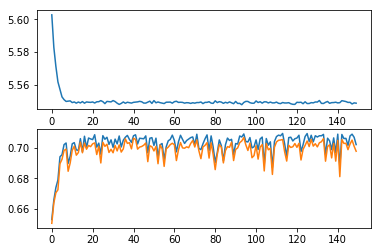

In [68]:
num_minibatches = len(train_loader)
losses = []
total_losses = []
accs = []
train_prediction = np.zeros_like(Y_train)
dev_prediction = np.zeros_like(Y_dev)
train_confidence = np.zeros_like(Y_train)
dev_confidence = np.zeros_like(Y_dev)

for epoch in range(NUM_EPOCH):

  #indices = np.random.permutation(epoch_train_x.shape[0]).astype('int')

  total_loss = 0

  for minibatch_X, minibatch_Y in train_loader:

    #idxs = indices[MINIBATCH_SIZE*minibatch: MINIBATCH_SIZE*(minibatch+1)]
    minibatch_X, minibatch_Y = minibatch_X.to(DEVICE), minibatch_Y.to(DEVICE)

    yhat = model(minibatch_X.float())
    
        #_, targets = minibatch_Y.max(dim=1)
    targets = torch.LongTensor(torch.argmax(minibatch_Y, 1))
    loss = criterion(yhat, Variable(targets)) #+ L2_WEIGHT * L2Regularization(model)#+ L1_WEIGHT * L1Regularization(model)
        #loss = criterion(yhat, minibatch_Y.float())
    #acc = torch.eq(yhat.round(), minibatch_Y).float().mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss)
    #accs.append(acc)

    total_loss += loss.item()

  model.eval()

  train_acc = 0
  train_prediction = np.round(model(X_train.to(DEVICE).float()).cpu().detach().numpy()).astype(int)
  train_confidence = model(X_train.to(DEVICE).float()).cpu().detach().numpy()
  # for minibatch_n, (train_X, train_Y) in enumerate(train_loader):
  #   train_prediction[minibatch_n * MINIBATCH_SIZE: (minibatch_n + 1) * MINIBATCH_SIZE] = model(train_X.to(DEVICE).float()).cpu().detach().numpy()

  dev_prediction = np.round(model(X_dev.to(DEVICE).float()).cpu().detach().numpy()).astype(int)
  dev_confidence = model(X_dev.to(DEVICE).float()).cpu().detach().numpy()
  # for minibatch_n, (dev_X, _) in enumerate(dev_loader):
  #   dev_prediction[minibatch_n * MINIBATCH_SIZE: (minibatch_n + 1) * MINIBATCH_SIZE] = model(dev_X.to(DEVICE).float()).cpu().detach().numpy()

  #print(np.equal(train_prediction, Y_train.numpy))

  train_acc = np.sum(np.equal(train_prediction, Y_train.numpy()).astype(int)) / train_size / len(outStim)
  dev_acc = np.sum(np.equal(dev_prediction, Y_dev.numpy()).astype(int)) / dev_size / len(outStim)

  accs.append([train_acc, dev_acc])

  total_losses.append(total_loss)

  print(f"Epoch #{epoch}  \t--  Train loss: {total_loss} \t Train Acc: {train_acc} \t Dev Acc: {dev_acc}")

accs = np.array(accs)

plt.figure
plt.subplot(2,1,1)
plt.plot(np.log(total_losses))

plt.subplot(2,1,2)
plt.plot(accs[:,0])
plt.plot(accs[:,1])

    # if epoch % 1 == 0:
    #     print("[{}/{}], loss: {} acc: {}".format(epoch,
    #     num_epoch, loss, acc))
    

In [105]:
num_test = 1000
num_cells = len(cell)
info = spikingPattern['info']
binWidth = timeConversion(info['binWidth'], source = 'mea', target = 'real')
testTime = 0.5
lastBinEdge = int(testTime / binWidth)

testData = np.zeros((num_test, num_cells))
testLabel = np.round(len(outStim) * np.random.random((num_test,)) - 0.5)
testDataLong = np.zeros((num_test, num_cells, lastBinEdge))

spikeRate_test = np.zeros((len(outStim), num_cells, lastBinEdge))
count = 0

print(f"Number of cells: {len(cell.keys())}")
print(f"List of cell IDs: {[k for k in cell.keys()]}")

for key, val in cell.items():
  #orientation = 
  for i in range(len(outStim)):
    spikeRate_test[i, count, :] = spikingPattern[key][i][:lastBinEdge] / binWidth
  count += 1


for n_e in range(num_test):
  if n_e % 2500 == 0: print(f"Simulating test #{n_e}")
  orientation = int(testLabel[n_e])
  sigma = np.tile(np.std(spikeRate_test[orientation, :, :], axis = 1).T, (lastBinEdge,1)).T
#     print(sigma)
  mu = spikeRate_test[orientation, :, :] - np.average(sigma, axis = None)
#     print(mu)
  rng = sigma * np.random.random(spikeRate_test[orientation, :, :].shape) + mu
  testDataLong[n_e, :, :] = rng
  testData[n_e, :] = np.sum(rng, axis = 1)
    
    
X_test = torch.from_numpy(testData.astype(float))
Y1 = testLabel.astype(int)
Y2 = np.zeros((len(Y1), len(outStim)))
Y2[np.arange(len(Y1)), Y1] = 1
Y_test = torch.from_numpy(Y2)


test_prediction = np.round(model(X_test.to(DEVICE).float()).cpu().detach().numpy()).astype(int)
test_confidence = model(X_test.to(DEVICE).float()).cpu().detach().numpy()

test_acc = np.sum(np.equal(test_prediction, Y_test.numpy()).astype(int)) / num_test / len(outStim)
print(f"Test accuracy: {test_acc}")

Number of cells: 19
List of cell IDs: ['5086', '4921', '5071', '5236', '5536', '5386', '5101', '4397', '4711', '4741', '4231', '4141', '661', '841', '3961', '3977', '4126', '557', '361']
Simulating test #0
Test accuracy: 0.93775


C:\Users\elton\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [12]:
Y.shape
print(f"Size minibatch: {minibatch_Y.shape}, size targets:{targets.shape}")
print(minibatch_Y[1:10,:])
print(targets[1:10])
print(yhat[1:10])
#yhat, Variable(targets)

Size minibatch: torch.Size([224, 4]), size targets:torch.Size([224])
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)
tensor([0, 3, 0, 2, 3, 0, 2, 1, 1])
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]], grad_fn=<SliceBackward>)


In [13]:
print(train_prediction[:,:])
print(Y_train)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)


Stats:
Mean error: 0.062153179198503494
Std error: 0.06353706866502762


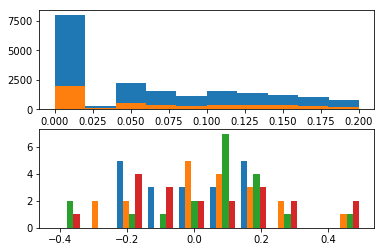

In [106]:
plt.subplot(2,1,1)
plt.hist(train_confidence[train_confidence < 0.2])
plt.hist(dev_confidence[dev_confidence < 0.2])
plt.subplot(2,1,2)
plt.hist(model.linear.weight.data.cpu())
print("Stats:")
print(f"Mean error: {np.average(train_confidence[train_confidence < 0.2])}")
print(f"Std error: {np.std(train_confidence[train_confidence < 0.2])}")

In [31]:
output_dict = {"Accuracy": accs.tolist(),
              "Losses": total_losses,
              "Train_Confidence": train_confidence.tolist(),
              "Dev_Confidence": dev_confidence.tolist(),
              "Weights": model.linear.weight.data.cpu().tolist()}

output_json = json.dumps(output_dict)

jsonfile = "G:\\My Drive\\PalankerLab\\retinal modeling\\datasets\\retina_RCS_E_4bar.json"
with open(jsonfile,'w') as f:
    json.dump(output_dict, f)